# Task 2

## Import Libraries

In [1]:
# import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, r_regression, f_regression
from sklearn.gaussian_process.kernels import Matern, RBF, CompoundKernel, Product, Sum, ExpSineSquared, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer, f1_score
from sklearn.decomposition import PCA

# boost algorithm
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

# torch
import torch
from torch import nn
from torch.nn import Module, Linear, Dropout
from torch.nn.functional import tanh, softmax, mse_loss, relu, sigmoid
from torch.optim import Adam, SGD

# bio library
import biosppy
from biosppy import storage
from biosppy.signals import ecg

DATA_DIR = "Data"
RESULT_DIR = "Result"

## Data Preprocessing

### Load Data

In [2]:
# Load Data
X_train_df = pd.read_csv(os.path.join(DATA_DIR, "X_train.csv"), header=0, index_col=0)
X_test_df = pd.read_csv(os.path.join(DATA_DIR, "X_test.csv"), header=0, index_col=0)
y_train_df = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv"), header=0, index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.ravel()

In [3]:
# 获取有效长度
X_train_len = []
for row in X_train:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_train_len.append(tail_id[0])
    else:
        X_train_len.append(X_train.shape[1])

X_test_len = []
for row in X_test:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_test_len.append(tail_id[0])
    else:
        X_test_len.append(X_test.shape[1])

X_train_len, X_test_len = np.array(X_train_len), np.array(X_test_len)

In [4]:
# get ecg info (比较松)
def check_template_result(templates: np.ndarray) -> list:
    # 检查有没有一个template里有多个心跳的情况
    check_result = True
    error_num = 0
    error_ids = []
    for template_i, template in enumerate(templates):
        peak_threshold = np.max(template) * 0.7
        peak_region = np.array(np.where(template > peak_threshold))
        if np.max(peak_region) - np.min(peak_region) > 0.5 * template.shape[0]:
            error_num += 1
            error_ids.append(template_i)
    return error_ids

def get_ecg_info(X, X_len):
    ts_lst = []
    filtered_lst = []
    rpeaks_lst = []
    templates_ts_lst = []
    templates_lst = []
    heart_rate_ts_lst = []
    heart_rate_lst = []

    error_ids = []
    part_error_lst = []
    for i, (signal, sig_len) in enumerate(zip(X, X_len)):
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal[:sig_len], sampling_rate=300., show=False)
        # check template
        # if check_ecg_result(templates) == False:
        #     error_ids.append(i)
        #     error_templates.append(templates)
        #     continue

        # template_error_ids = check_template_result(templates) # 以较轻松的方式处理ecg处理异常
        template_error_ids = [] # 以较轻松的方式处理ecg处理异常

        # delete error data
        rpeaks = np.delete(rpeaks, template_error_ids, axis=0)
        templates_ts = np.delete(templates_ts, template_error_ids, axis=0)
        templates = np.delete(templates, template_error_ids, axis=0)
        if len(templates) < 1:
            error_ids.append(i)
            continue

        if len(template_error_ids) > 0:
            part_error_lst.append(len(ts_lst))

        ts_lst.append(ts) # Signal time axis reference (seconds)
        filtered_lst.append(filtered) # Filtered ECG signal
        rpeaks_lst.append(rpeaks) # R-peak location indices
        templates_ts_lst.append(templates_ts) # Templates time axis reference
        templates_lst.append(templates) # Extracted heartbeat templates
        heart_rate_ts_lst.append(heart_rate_ts) # Heart rate time axis reference (seconds)
        heart_rate_lst.append(heart_rate) # Instantaneous heart rate (bpm)
    return ts_lst, filtered_lst, rpeaks_lst, templates_ts_lst, templates_lst, heart_rate_ts_lst, heart_rate_lst

ts_lst, filtered_lst, rpeaks_lst, templates_ts_lst, templates_lst, heart_rate_ts_lst, heart_rate_lst = get_ecg_info(X_train, X_train_len)
ts_lst_test, filtered_lst_test, rpeaks_lst_test, templates_ts_lst_test, templates_lst_test, heart_rate_ts_lst_test, heart_rate_lst_test = get_ecg_info(X_test, X_test_len)

In [ ]:
# get ecg features (比较严)
ts_lst = []
filtered_lst = []
rpeaks_lst = []
templates_ts_lst = []
templates_lst = []
heart_rate_ts_lst = []
heart_rate_lst = []

def check_template_result(templates: np.ndarray) -> list:
    # 检查有没有一个template里有多个心跳的情况
    check_result = True
    error_num = 0
    error_ids = []
    for template_i, template in enumerate(templates):
        peak_threshold = np.max(template) * 0.7
        peak_region = np.array(np.where(template > peak_threshold))
        if np.max(peak_region) - np.min(peak_region) > 0.5 * template.shape[0]:
            error_num += 1
            error_ids.append(template_i)
    return error_ids

error_ids = []
for i, (signal, sig_len) in enumerate(zip(X_train, X_train_len)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal[:sig_len], sampling_rate=300., show=False)
    # check template
    # if check_ecg_result(templates) == False:
    #     error_ids.append(i)
    #     error_templates.append(templates)
    #     continue
    template_error_ids = check_template_result(templates)
    if len(template_error_ids) > 0:
        error_ids.append(i)
        continue

    ts_lst.append(ts) # Signal time axis reference (seconds)
    filtered_lst.append(filtered) # Filtered ECG signal
    rpeaks_lst.append(rpeaks) # R-peak location indices
    templates_ts_lst.append(templates_ts) # Templates time axis reference
    templates_lst.append(templates) # Extracted heartbeat templates
    heart_rate_ts_lst.append(heart_rate_ts) # Heart rate time axis reference (seconds)
    heart_rate_lst.append(heart_rate) # Instantaneous heart rate (bpm)

y_train = np.delete(y_train, error_ids, axis=0)

In [ ]:
# 统计y_train的值
class_0_num = np.sum(y_train == 0)
class_1_num = np.sum(y_train == 1)
class_2_num = np.sum(y_train == 2)
class_3_num = np.sum(y_train == 3)
print("class 0 count: {}".format(class_0_num))
print("class 1 count: {}".format(class_1_num))
print("class 2 count: {}".format(class_2_num))
print("class 3 count: {}".format(class_3_num))

class 0 count: 2653
class 1 count: 275
class 2 count: 1180
class 3 count: 42


In [5]:
# get average template
max_height = None
for templates in templates_lst:
    for template in templates:
        if max_height is None or np.max(template) > max_height:
            max_height = np.max(template)

# scaler现在只是简单的缩放，不确定绝对高度有没有用
def scaler(template: np.array):
    result = template / max_height
    return result

# 对所有的templates进行缩放
templates_lst = [scaler(templates) for templates in templates_lst]

def get_average_templates(templates):
    templates = scaler(templates)
    avg_templates = templates.sum(axis=0) / templates.shape[0]
    return avg_templates

avg_templates_lst = [get_average_templates(templates) for templates in templates_lst]

157

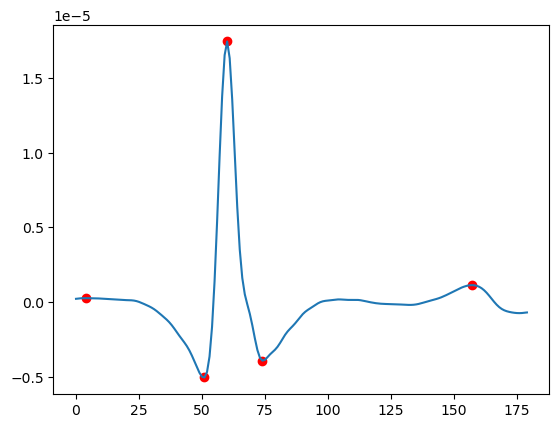

In [6]:
# 测试获取RQPST
templates = avg_templates_lst[10]

def get_PQRST_from_template(template: np.array):
    error_state = False

    # get R
    R_id = np.where(template == np.max(template))[0][0]
    R = template[R_id]

    # get Q
    if R_id == 0:
        Q_id = R_id
        error_state = True
    else:
        Q_id = np.where(template[:R_id] == np.min(template[:R_id]))[0][0]
    Q = template[Q_id]

    # get P
    if Q_id == 0:
        P_id = 0
        error_state = True
    else:
        P_id = np.where(template[:Q_id] == np.max(template[:Q_id]))[0][0]
    P = template[P_id]

    # get S
    if R_id == 179:
        S_id = R_id
        error_state = True
    else:
        S_id = np.where(template[R_id + 1:] == np.min(template[R_id + 1:]))[0][0] + R_id + 1
    S = template[S_id]

    # get T
    if S_id == 179:
        T_id = 179
        error_state = True
    else:
        T_id = np.where(template[S_id + 1:] == np.max(template[S_id + 1:]))[0][0] + S_id + 1
    T = template[T_id]

    # assert (P_id < Q_id and Q_id < R_id and R_id < S_id and S_id < T_id)

    # cal interval
    QRS = S_id - Q_id
    PR = R_id - P_id
    PQ = R_id - Q_id
    ST = T_id - S_id
    QT = T_id - Q_id
    return (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), error_state

(P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), _ = get_PQRST_from_template(templates)

plt.plot(np.arange(0, templates.shape[0], 1), templates)
plt.scatter([P_id, Q_id, R_id, S_id, T_id], [P, Q, R, S, T], c="r")
T_id

In [7]:
# get P Q R S T
def get_PQRST(templates_lst):
    PQRST = []
    for templates_i, templates in enumerate(templates_lst):
        template_PQRST = {
            "P": [], 
            "Q": [], 
            "R": [], 
            "S": [], 
            "T": [], 
            "P_id": [], 
            "Q_id": [], 
            "R_id": [], 
            "S_id": [], 
            "T_id": [], 
            "QRS": [], 
            "PR": [], 
            "PQ": [], 
            "ST": [], 
            "QT": [], 
            "error_state": []
        }
        for template_i, template in enumerate(templates):
            (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), error_state = get_PQRST_from_template(template)
            template_PQRST["P"].append(P)
            template_PQRST["Q"].append(Q)
            template_PQRST["R"].append(R)
            template_PQRST["S"].append(S)
            template_PQRST["T"].append(T)
            template_PQRST["P_id"].append(P_id)
            template_PQRST["Q_id"].append(Q_id)
            template_PQRST["R_id"].append(R_id)
            template_PQRST["S_id"].append(S_id)
            template_PQRST["T_id"].append(T_id)
            template_PQRST["QRS"].append(QRS)
            template_PQRST["PR"].append(PR)
            template_PQRST["PQ"].append(PQ)
            template_PQRST["ST"].append(ST)
            template_PQRST["QT"].append(QT)
            template_PQRST["error_state"].append(error_state)
        PQRST.append(template_PQRST)
    return PQRST
PQRST = get_PQRST(templates_lst)
PQRST_test = get_PQRST(templates_lst_test)

In [8]:
# 处理rpeak
rpeaks_new = []
for rpeaks in rpeaks_lst:
    rpeaks_iterval = []
    for i in range(1, rpeaks.shape[0]):
        rpeaks_iterval.append(rpeaks[i] - rpeaks[i - 1])
    rpeaks_iterval = np.array(rpeaks_iterval)
    rpeaks_new.append(rpeaks_iterval)

rpeaks_new_test = []
for rpeaks in rpeaks_lst_test:
    rpeaks_iterval = []
    for i in range(1, rpeaks.shape[0]):
        rpeaks_iterval.append(rpeaks[i] - rpeaks[i - 1])
    rpeaks_iterval = np.array(rpeaks_iterval)
    rpeaks_new_test.append(rpeaks_iterval)

# 处理heart_rate
heart_rate_new = []
for heart_rate in heart_rate_lst:
    if heart_rate.shape[0] == 0:
        heart_rate = np.array(-100)
    heart_rate_new.append(heart_rate)

heart_rate_new_test = []
for heart_rate in heart_rate_lst_test:
    if heart_rate.shape[0] == 0:
        heart_rate = np.array(-100)
    heart_rate_new_test.append(heart_rate)

In [9]:
# 统计各种指标
def get_valid_features(rpeaks, heart_rate, PQRST):
    # rpeak
    rpeak_mean = np.array([np.average(x) for x in rpeaks])
    rpeak_median = np.array([np.median(x) for x in rpeaks])
    rpeak_std = np.array([np.std(x) for x in rpeaks])
    rpeak_min = np.array([np.min(x) for x in rpeaks])
    rpeak_max = np.array([np.max(x) for x in rpeaks])

    # heart rate
    hr_mean = np.array([np.average(x) for x in heart_rate])
    hr_median = np.array([np.median(x) for x in heart_rate])
    hr_std = np.array([np.std(x) for x in heart_rate])
    hr_min = np.array([np.min(x) for x in heart_rate])
    hr_max = np.array([np.max(x) for x in heart_rate])

    # PQRST
    # P
    P_mean = np.array([np.mean(x["P"]) for x in PQRST])
    P_median = np.array([np.median(x["P"]) for x in PQRST])
    P_std = np.array([np.std(x["P"]) for x in PQRST])
    P_min = np.array([np.min(x["P"]) for x in PQRST])
    P_max = np.array([np.max(x["P"]) for x in PQRST])

    # Q
    Q_mean = np.array([np.mean(x["Q"]) for x in PQRST])
    Q_median = np.array([np.median(x["Q"]) for x in PQRST])
    Q_std = np.array([np.std(x["Q"]) for x in PQRST])
    Q_min = np.array([np.min(x["Q"]) for x in PQRST])
    Q_max = np.array([np.max(x["Q"]) for x in PQRST])

    # R
    R_mean = np.array([np.mean(x["R"]) for x in PQRST])
    R_median = np.array([np.median(x["R"]) for x in PQRST])
    R_std = np.array([np.std(x["R"]) for x in PQRST])
    R_min = np.array([np.min(x["R"]) for x in PQRST])
    R_max = np.array([np.max(x["R"]) for x in PQRST])

    # S
    S_mean = np.array([np.mean(x["S"]) for x in PQRST])
    S_median = np.array([np.median(x["S"]) for x in PQRST])
    S_std = np.array([np.std(x["S"]) for x in PQRST])
    S_min = np.array([np.min(x["S"]) for x in PQRST])
    S_max = np.array([np.max(x["S"]) for x in PQRST])

    # T
    T_mean = np.array([np.mean(x["T"]) for x in PQRST])
    T_median = np.array([np.median(x["T"]) for x in PQRST])
    T_std = np.array([np.std(x["T"]) for x in PQRST])
    T_min = np.array([np.min(x["T"]) for x in PQRST])
    T_max = np.array([np.max(x["T"]) for x in PQRST])

    # P_i
    P_id_mean = np.array([np.mean(x["P_id"]) for x in PQRST])
    P_id_median = np.array([np.median(x["P_id"]) for x in PQRST])
    P_id_std = np.array([np.std(x["P_id"]) for x in PQRST])
    P_id_min = np.array([np.min(x["P_id"]) for x in PQRST])
    P_id_max = np.array([np.max(x["P_id"]) for x in PQRST])

    # Q_i
    Q_id_mean = np.array([np.mean(x["Q_id"]) for x in PQRST])
    Q_id_median = np.array([np.median(x["Q_id"]) for x in PQRST])
    Q_id_std = np.array([np.std(x["Q_id"]) for x in PQRST])
    Q_id_min = np.array([np.min(x["Q_id"]) for x in PQRST])
    Q_id_max = np.array([np.max(x["Q_id"]) for x in PQRST])

    # R_i
    R_id_mean = np.array([np.mean(x["R_id"]) for x in PQRST])
    R_id_median = np.array([np.median(x["R_id"]) for x in PQRST])
    R_id_std = np.array([np.std(x["R_id"]) for x in PQRST])
    R_id_min = np.array([np.min(x["R_id"]) for x in PQRST])
    R_id_max = np.array([np.max(x["R_id"]) for x in PQRST])

    # S_i
    S_id_mean = np.array([np.mean(x["S_id"]) for x in PQRST])
    S_id_median = np.array([np.median(x["S_id"]) for x in PQRST])
    S_id_std = np.array([np.std(x["S_id"]) for x in PQRST])
    S_id_min = np.array([np.min(x["S_id"]) for x in PQRST])
    S_id_max = np.array([np.max(x["S_id"]) for x in PQRST])

    # T_i
    T_id_mean = np.array([np.mean(x["T_id"]) for x in PQRST])
    T_id_median = np.array([np.median(x["T_id"]) for x in PQRST])
    T_id_std = np.array([np.std(x["T_id"]) for x in PQRST])
    T_id_min = np.array([np.min(x["T_id"]) for x in PQRST])
    T_id_max = np.array([np.max(x["T_id"]) for x in PQRST])

    # QRS
    QRS_mean = np.array([np.mean(x["QRS"]) for x in PQRST])
    QRS_median = np.array([np.median(x["QRS"]) for x in PQRST])
    QRS_std = np.array([np.std(x["QRS"]) for x in PQRST])
    QRS_min = np.array([np.min(x["QRS"]) for x in PQRST])
    QRS_max = np.array([np.max(x["QRS"]) for x in PQRST])

    # PR
    PR_mean = np.array([np.mean(x["PR"]) for x in PQRST])
    PR_median = np.array([np.median(x["PR"]) for x in PQRST])
    PR_std = np.array([np.std(x["PR"]) for x in PQRST])
    PR_min = np.array([np.min(x["PR"]) for x in PQRST])
    PR_max = np.array([np.max(x["PR"]) for x in PQRST])

    # PQ
    PQ_mean = np.array([np.mean(x["PQ"]) for x in PQRST])
    PQ_median = np.array([np.median(x["PQ"]) for x in PQRST])
    PQ_std = np.array([np.std(x["PQ"]) for x in PQRST])
    PQ_min = np.array([np.min(x["PQ"]) for x in PQRST])
    PQ_max = np.array([np.max(x["PQ"]) for x in PQRST])

    # ST
    ST_mean = np.array([np.mean(x["ST"]) for x in PQRST])
    ST_median = np.array([np.median(x["ST"]) for x in PQRST])
    ST_std = np.array([np.std(x["ST"]) for x in PQRST])
    ST_min = np.array([np.min(x["ST"]) for x in PQRST])
    ST_max = np.array([np.max(x["ST"]) for x in PQRST])

    # QT
    QT_mean = np.array([np.mean(x["QT"]) for x in PQRST])
    QT_median = np.array([np.median(x["QT"]) for x in PQRST])
    QT_std = np.array([np.std(x["QT"]) for x in PQRST])
    QT_min = np.array([np.min(x["QT"]) for x in PQRST])
    QT_max = np.array([np.max(x["QT"]) for x in PQRST])

    # error_state
    error_count = np.array([np.sum(x["error_state"]) for x in PQRST])
    error_mean = np.array([np.mean(x["error_state"]) for x in PQRST])

# valid features
    valid_features = [
        # rpeak
        rpeak_mean, 
        rpeak_median, 
        rpeak_std, 
        rpeak_min, 
        rpeak_max, 
        # heart rate
        hr_mean, 
        hr_median, 
        hr_std, 
        hr_min, 
        hr_max, 
        # P
        P_mean, 
        P_median, 
        P_std, 
        P_min, 
        P_max, 
        # Q
        Q_mean, 
        Q_median, 
        Q_std, 
        Q_min, 
        Q_max, 
        # R
        R_mean, 
        R_median, 
        R_std, 
        R_min, 
        R_max, 
        # S
        S_mean, 
        S_median, 
        S_std, 
        S_min, 
        S_max, 
        # T
        T_mean, 
        T_median, 
        T_std, 
        T_min, 
        T_max, 
        # P_id
        P_id_mean, 
        P_id_median, 
        P_id_std, 
        P_id_min, 
        P_id_max, 
        # Q_id
        Q_id_mean, 
        Q_id_median, 
        Q_id_std, 
        Q_id_min, 
        Q_id_max, 
        # R_id
        R_id_mean, 
        R_id_median, 
        R_id_std, 
        R_id_min, 
        R_id_max, 
        # S_id
        S_id_mean, 
        S_id_median, 
        S_id_std, 
        S_id_min, 
        S_id_max, 
        # T_id
        T_id_mean, 
        T_id_median, 
        T_id_std, 
        T_id_min, 
        T_id_max, 
        # QRS
        QRS_mean, 
        QRS_median, 
        QRS_std, 
        QRS_min, 
        QRS_max, 
        # PR
        PR_mean, 
        PR_median, 
        PR_std, 
        PR_min, 
        PR_max, 
        # PQ
        PQ_mean, 
        PQ_median, 
        PQ_std, 
        PQ_min, 
        PQ_max, 
        # ST
        ST_mean, 
        ST_median, 
        ST_std, 
        ST_min, 
        ST_max, 
        # QT
        QT_mean, 
        QT_median, 
        QT_std, 
        QT_min, 
        QT_max, 
        # error state
        error_count, 
        error_mean, 
    ]
    return valid_features

valid_features = get_valid_features(rpeaks_new, heart_rate_new, PQRST)
valid_features_test = get_valid_features(rpeaks_new_test, heart_rate_new_test, PQRST_test)

In [11]:
# 生成新的训练数据 X_train_features
X_train_features = []
for feature in valid_features:
    feature = feature.reshape((X_train.shape[0], -1))
    X_train_features.append(feature)
X_train_features = np.concatenate(X_train_features, axis=1)

X_test_features = []
for feature in valid_features_test:
    feature = feature.reshape((X_test.shape[0], -1))
    X_test_features.append(feature)
X_test_features = np.concatenate(X_test_features, axis=1)

scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

## 训练模型

In [12]:
# CatBoost (run)
# 模型：换loss function
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train_features)):
    # split validation data
    fold_X_train = X_train_features[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_valid = X_train_features[valid_ids]
    fold_y_valid = y_train[valid_ids]

    # train model
    model = cat.CatBoostClassifier(iterations=1500, learning_rate=0.05, rsm=0.6, max_depth=5)
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(f1_score(fold_y_valid.ravel(), fold_y_pred.ravel(), average="micro"))
fold_score = np.average(fold_scores)
print(fold_score)

0:	learn: 1.3280968	total: 159ms	remaining: 3m 57s
1:	learn: 1.2783755	total: 163ms	remaining: 2m 2s
2:	learn: 1.2353403	total: 172ms	remaining: 1m 26s
3:	learn: 1.1937225	total: 177ms	remaining: 1m 6s
4:	learn: 1.1573246	total: 186ms	remaining: 55.5s
5:	learn: 1.1229164	total: 190ms	remaining: 47.3s
6:	learn: 1.0912912	total: 199ms	remaining: 42.5s
7:	learn: 1.0631997	total: 204ms	remaining: 38s
8:	learn: 1.0382565	total: 212ms	remaining: 35.1s
9:	learn: 1.0144432	total: 216ms	remaining: 32.2s
10:	learn: 0.9915229	total: 224ms	remaining: 30.3s
11:	learn: 0.9704759	total: 229ms	remaining: 28.4s
12:	learn: 0.9519268	total: 237ms	remaining: 27.1s
13:	learn: 0.9353467	total: 241ms	remaining: 25.6s
14:	learn: 0.9186222	total: 250ms	remaining: 24.8s
15:	learn: 0.9012183	total: 255ms	remaining: 23.7s
16:	learn: 0.8855594	total: 265ms	remaining: 23.1s
17:	learn: 0.8722124	total: 270ms	remaining: 22.2s
18:	learn: 0.8601604	total: 279ms	remaining: 21.8s
19:	learn: 0.8466029	total: 284ms	remaini

In [13]:
# 预测数据
model = cat.CatBoostClassifier(iterations=1500, learning_rate=0.05, rsm=0.6, max_depth=5)
model.fit(X_train_features, y_train)
y_pred = model.predict(X_test_features)

0:	learn: 1.3284353	total: 5.13ms	remaining: 7.68s
1:	learn: 1.2800975	total: 9.8ms	remaining: 7.34s
2:	learn: 1.2340037	total: 18.4ms	remaining: 9.18s
3:	learn: 1.1932927	total: 23.1ms	remaining: 8.66s
4:	learn: 1.1568404	total: 31.7ms	remaining: 9.48s
5:	learn: 1.1204889	total: 35.9ms	remaining: 8.94s
6:	learn: 1.0890570	total: 45.3ms	remaining: 9.66s
7:	learn: 1.0600477	total: 49.9ms	remaining: 9.31s
8:	learn: 1.0331091	total: 58ms	remaining: 9.6s
9:	learn: 1.0095650	total: 62.4ms	remaining: 9.29s
10:	learn: 0.9875952	total: 70.8ms	remaining: 9.58s
11:	learn: 0.9676783	total: 75.3ms	remaining: 9.34s
12:	learn: 0.9493773	total: 84ms	remaining: 9.61s
13:	learn: 0.9318107	total: 88.3ms	remaining: 9.37s
14:	learn: 0.9148929	total: 96.8ms	remaining: 9.59s
15:	learn: 0.9001002	total: 101ms	remaining: 9.38s
16:	learn: 0.8851966	total: 110ms	remaining: 9.57s
17:	learn: 0.8719675	total: 115ms	remaining: 9.44s
18:	learn: 0.8596168	total: 124ms	remaining: 9.65s
19:	learn: 0.8469569	total: 128m

In [15]:
result_df = pd.DataFrame(y_pred.reshape((-1, 1)), columns=["y"]).reset_index()
result_df.columns = ["id", "y"]
result_df.to_csv("./Result/result.csv", index=False)